In [ ]:
import pandas as pd 
import pennylane.numpy as np 
import pennylane as qml 


from silence_tensorflow import silence_tensorflow 
silence_tensorflow() 
import tensorflow as tf 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
dataframe = pd.read_csv(r'vento.csv')
dataset = dataframe.values


X=dataset[:,3:]
Y=dataset[:,2:3]

scaler = MinMaxScaler()
StdScaler=scaler.fit(X)
X=scaler.transform(X)

scaler = MinMaxScaler()
StdScaler2=scaler.fit(Y)
Y=scaler.transform(Y)

months = len(Y)
TRAIN_TEST_SPLIT = 0.987

split = split = int(months * TRAIN_TEST_SPLIT)
TrainX = X[0:split]
TestX = X[split:]

TrainY = Y[0:split]
TestY = Y[split:]


print("Len(Train):",len(TrainX))
print("Len(Test):",len(TestX))

Len(Train): 361
Len(Test): 5


In [ ]:
def H_layer(n_qubits):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def Data_AngleEmbedding_layer(inputs):
    qml.templates.AngleEmbedding(inputs,rotation='Y', wires=range(n_qubits))

def RY_layer(w):
    print(w.shape)
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def ROT_layer(w):
    for i in range(n_qubits):
        qml.Rot(*w[i],wires=i)
    
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])

In [4]:
n_qubits = 8
n_layers = 1

dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev)
def qnode(inputs, weights_1):
    H_layer(n_qubits)
    Data_AngleEmbedding_layer(inputs)
    for k in range(n_layers):
        entangling_layer(n_qubits)
        ROT_layer(weights_1[k])
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [5]:
weight_shapes = {"weights_1": (n_layers,n_qubits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
Activation=tf.keras.layers.Activation(activations.linear)
clayer_2 = tf.keras.layers.Dense(1,kernel_initializer='normal')
model = tf.keras.models.Sequential([qlayer,Activation, clayer_2])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(opt, loss="mae")

In [ ]:
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.00001)
fitting = model.fit(TrainX, TrainY, epochs=30, batch_size=10, validation_split=0.1, callbacks=[re], verbose=1)

Epoch 1/30
33/33 [==============================] - 9s 237ms/step - loss: 0.1263 - val_loss: 0.1730 - lr: 0.1000
Epoch 2/30
33/33 [==============================] - 8s 237ms/step - loss: 0.0738 - val_loss: 0.0664 - lr: 0.1000
Epoch 3/30
33/33 [==============================] - 8s 232ms/step - loss: 0.0568 - val_loss: 0.0500 - lr: 0.1000
Epoch 4/30
33/33 [==============================] - 8s 230ms/step - loss: 0.0455 - val_loss: 0.0455 - lr: 0.1000
Epoch 5/30
33/33 [==============================] - 8s 229ms/step - loss: 0.0496 - val_loss: 0.0401 - lr: 0.1000
Epoch 6/30
33/33 [==============================] - 8s 230ms/step - loss: 0.0504 - val_loss: 0.0479 - lr: 0.1000
Epoch 7/30
33/33 [==============================] - 8s 231ms/step - loss: 0.0607 - val_loss: 0.0414 - lr: 0.1000
Epoch 8/30
33/33 [==============================] - ETA: 0s - loss: 0.0457
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
33/33 [==============================] - 8s 231ms/step - lo

In [7]:
y_predict=model.predict(TestX,verbose=1)
y_predict=y_predict.T
y_predict=y_predict[0]

1/1 [==============================] - 0s 157ms/step


In [8]:
newTestY = scaler.inverse_transform(TestY)
newy_predict = scaler.inverse_transform(y_predict.reshape(-1, 1))

In [9]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(newTestY, newy_predict))

Mean Absolute Error: 0.15651177787780757


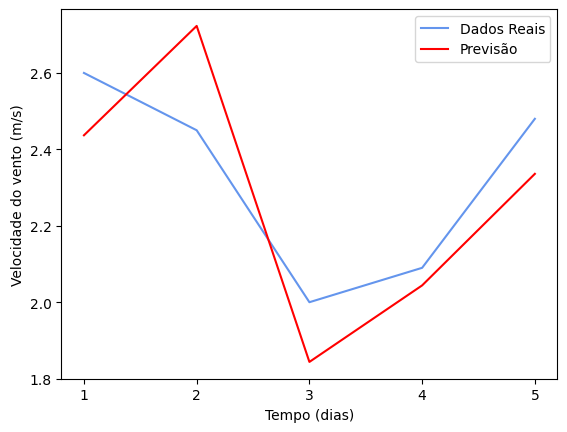

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

x_range = range(1, len(newTestY) + 1)

fig, ax = plt.subplots()
ax.plot(x_range, newTestY, color='cornflowerblue', linestyle='-', label='Dados Reais')
ax.plot(x_range, newy_predict, color='red', linestyle='-', label='Previsão')

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel('Tempo (dias)')
plt.ylabel('Velocidade do vento (m/s)')
plt.legend()
plt.show()

In [11]:
newTestY

array([[2.6 ],
       [2.45],
       [2.  ],
       [2.09],
       [2.48]])

In [12]:
newy_predict

array([[2.4368222],
       [2.7230551],
       [1.8437388],
       [2.043999 ],
       [2.3359363]], dtype=float32)

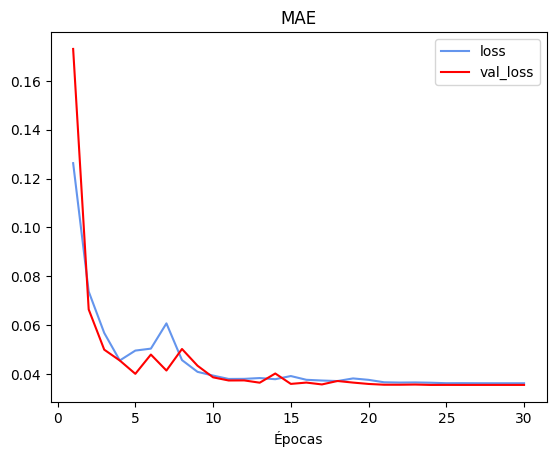

In [ ]:
import matplotlib.pyplot as plt

epochs_adjusted = [epoch + 1 for epoch in fitting.epoch]

plt.plot(epochs_adjusted, fitting.history.get('loss'), color='cornflowerblue', linestyle='-', label='loss')
plt.plot(epochs_adjusted, fitting.history.get('val_loss'), color='red', linestyle='-', label='val_loss')
plt.title('MAE')
plt.xlabel('Épocas')  
plt.legend()
plt.show()

In [14]:
print(fitting.history.get('loss'))

[0.12629711627960205, 0.07375252991914749, 0.0567903034389019, 0.045530546456575394, 0.049577388912439346, 0.05037539079785347, 0.060714419931173325, 0.0456862598657608, 0.04087261110544205, 0.03934840112924576, 0.03796391561627388, 0.03799869120121002, 0.038333773612976074, 0.03786146640777588, 0.03915391489863396, 0.03761749714612961, 0.037322036921978, 0.037105076014995575, 0.03817790374159813, 0.037599217146635056, 0.03659920021891594, 0.036483652889728546, 0.03653467446565628, 0.036419954150915146, 0.03622197359800339, 0.03624407574534416, 0.03621385991573334, 0.03620301932096481, 0.03620285913348198, 0.03620287403464317]


In [15]:
fitting.history.get('val_loss')

[0.17304997146129608,
 0.06641475111246109,
 0.04995062202215195,
 0.04551653936505318,
 0.04006107151508331,
 0.04794853925704956,
 0.0414128378033638,
 0.050231922417879105,
 0.04337572678923607,
 0.03862658515572548,
 0.03733811154961586,
 0.037368401885032654,
 0.03643001988530159,
 0.040197741240262985,
 0.035937704145908356,
 0.03647661954164505,
 0.03572031110525131,
 0.03713025152683258,
 0.036477528512477875,
 0.03591626510024071,
 0.0356021523475647,
 0.035594698041677475,
 0.03567305952310562,
 0.03552023321390152,
 0.03553204983472824,
 0.03552168235182762,
 0.035524751991033554,
 0.0355251207947731,
 0.035521768033504486,
 0.03552132844924927]